In [1]:
import sys
import platform

print(sys.version)
print(platform.processor())

3.8.3 (default, Jun 23 2020, 17:22:06) 
[GCC Intel(R) C++ gcc 9.3 mode]
x86_64


In [2]:
import os
import re
from collections import defaultdict
from time import time, ctime
from typing import List, Tuple

import seaborn as sns
import numpy as np
import pandas as pd
import tsplib95 as tsp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


pd.options.display.float_format = '{:.0f}%'.format
sns.set_style("darkgrid")
log = 'file.log'

In [3]:
from lin_kernighan.algorithms.structures.matrix import adjacency_matrix
from lin_kernighan.algorithms.utils.generator import generator
from lin_kernighan.utils import draw_tour

from lin_kernighan.lkh_search import LKHSearch
from lin_kernighan.tabu_search import TabuSearch

In [4]:
import multiprocessing as mp

In [5]:
def mp_test(search, matrix, opt, iterations=10, swap=2):
    t_start = time()
    searcher = search(matrix=matrix, two_opt=True, init='two_opt', opt=opt)
    searcher.optimize(iterations=iterations, swap=swap)
    return (time() - t_start) / iterations, searcher.length, searcher.tour.tolist()

def mp_runner(search, path, tries, opt='lkh_opt', iterations=10, swap=2):
    points_dict = tsp.load(path).as_dict()['node_coords']
    points = np.zeros((len(points_dict), 2), dtype=np.float)
    for key, point in points_dict.items():
        points[key - 1][0], points[key - 1][1] = point[0], point[1]
    matrix = adjacency_matrix(points)
    frame = defaultdict(list)
    
    args = [(search, matrix, opt, iterations, swap)] * tries
    
    with mp.Pool(tries) as p:
        result = p.starmap(mp_test, args)
    
    for _time, _length, _tour in result:
        frame['time'].append(_time)
        frame['length'].append(_length)
        frame['tour'].append(_tour)
    return pd.DataFrame(frame)

def mp_quality_test(search, opt, name, path, start, stop, step, directory, tries=15, swap=2):
    for iterations in range(start, stop + 1, step):
        logger(f'{iterations} time: {ctime()}\n')
        frame = mp_runner(search, path, tries, opt, iterations, swap)
        frame.to_csv(f'./{directory}/{name}/{name}_{iterations}_{tries}.csv', index=False, encoding='utf-8')
        logger(f'Done time: {ctime()}\n\n')
            
def mp_executor(search, start, stop, step, directory, tasks, tries=15, swap=2, opt='two_opt'):
    if not os.path.exists(directory):
        os.mkdir(directory)
    for path, name in tasks:
        if not os.path.exists(f'./{directory}/{str(name)}'):
            os.mkdir(f'./{directory}/{str(name)}')  
        logger(f'Start: {name}, time: {ctime()}\n\n')
        mp_quality_test(search, opt, name, path, start, stop, step, directory, tries, swap)
        logger(f'Done: {name}, time: {ctime()}\n\n')
    logger(f'Done {directory}, time: {ctime()}\n\n')
        
def logger(text):
    with open(log, 'a+') as file:
        file.write(text)

In [6]:
lkh_sol = {'rat195': 2333.873187700557, 'rat575': 6795.967519847072, 'rat783': 8842.994959838505, 
           'rat99': 1219.2437686776964, 'a280': 2586.7696475631606, 'ali535': 2009.4468071460146, 
           'att48': 33523.70850743559, 'att532': 86742.42216209782, 'dsj1000': 18659689.564624883, 
           'ulysses16': 73.98761804517501, 'berlin52': 7544.36590190409, 'bier127': 118293.52381566976, 
           'lin105': 14382.99593345118, 'lin318': 42042.53508905061, 'p654': 34646.834709581795, 
           'pcb442': 50783.547513735335, 'rd100': 7910.396210215009, 'rd400': 15275.984984855848, 
           'ts225': 126645.93368025386, 'u1060': 224085.59356065158, 'u1432': 152999.1284948489, 
           'u159': 42075.67004001936, 'u1817': 57837.76626161771, 'u2152': 65024.12568286906, 
           'u2319': 234267.12418609392, 'u574': 36934.771413684284, 'u724': 41907.722274946165, 
           'pr107': 44301.68367681015, 'pr124': 59030.735702981634, 'pr136': 96770.92412211717, 
           'pr144': 58587.14195185409, 'pr152': 73683.64062763304, 'pr226': 80370.25705287066, 
           'pr2392': 378062.82619143813, 'pr264': 49135.00496337509, 'pr299': 48194.92010274798, 
           'pr439': 107215.3017147512, 'pr76': 108159.43827413769, 'gr137': 706.2898161763319, 
           'gr202': 486.3493863411825, 'gr229': 1635.3110858973698, 'gr431': 1924.1487425292512,
           'gr666': 3088.4658424373274, 'gr96': 510.88631488679465, 'fl1400': 20328.546292851803, 
           'fl1577': 22275.072438907973, 'fl3795': 28707.716884694397, 'fl417': 11914.313330563053}

In [7]:
def get_data(dir_path, frame, lkh):
    for task in lkh_sol:
        frame['size'].append(int(re.findall(r'\d+', task)[0]))
        for i in range(5, 16, 5):
            data = pd.read_csv(f'{dir_path}/{task}/{task}_{i}_10.csv')
            frame[f'{i}_average'].append(100 / lkh[task] * data['length'].mean() - 100)
            frame[f'{i}_min'].append(100 / lkh[task] * data['length'].min() - 100)

# LKHSearch

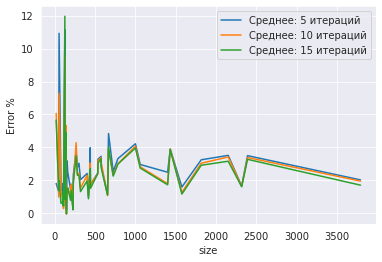

2.730359515433275 2.424549829882119 2.2234000570356036


In [8]:
lkhs = defaultdict(list)
get_data('./quality/LKHS', lkhs, lkh_sol)
frame = pd.DataFrame(lkhs)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_average', data=frame, label='Среднее: 5 итераций')
sns.lineplot(x="size", y='10_average', data=frame, label='Среднее: 10 итераций')
sns.lineplot(x="size", y='15_average', data=frame, label='Среднее: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lkhs_average.png")
plt.show()
print(frame['5_average'].mean(), frame['10_average'].mean(), frame['15_average'].mean())

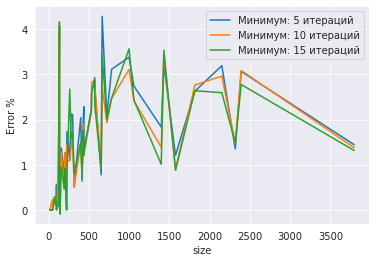

1.5044814574826997 1.3784807041131624 1.3324095118041377


In [9]:
lkhs = defaultdict(list)
get_data('./quality/LKHS', lkhs, lkh_sol)
frame = pd.DataFrame(lkhs)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_min', data=frame, label='Минимум: 5 итераций')
sns.lineplot(x="size", y='10_min', data=frame, label='Минимум: 10 итераций')
sns.lineplot(x="size", y='15_min', data=frame, label='Минимум: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lkhs_min.png")
plt.show()
print(frame['5_min'].mean(), frame['10_min'].mean(), frame['15_min'].mean())

# Tabu with LK

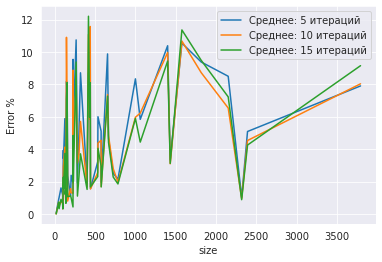

4.792343831678177 4.163260373575177 3.7206270111250794


In [10]:
tabu_lk = defaultdict(list)
get_data('./quality/TabuLK', tabu_lk, lkh_sol)
frame = pd.DataFrame(tabu_lk)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_average', data=frame, label='Среднее: 5 итераций')
sns.lineplot(x="size", y='10_average', data=frame, label='Среднее: 10 итераций')
sns.lineplot(x="size", y='15_average', data=frame, label='Среднее: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lk_average.png")
plt.show()
print(frame['5_average'].mean(), frame['10_average'].mean(), frame['15_average'].mean())

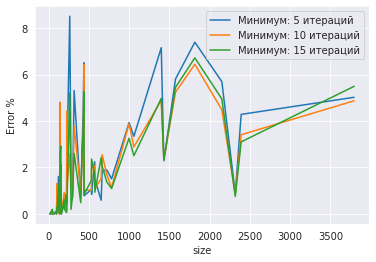

2.121624130387367 1.8803004134742978 1.7567571887338638


In [11]:
tabu_lk = defaultdict(list)
get_data('./quality/TabuLK', tabu_lk, lkh_sol)
frame = pd.DataFrame(tabu_lk)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_min', data=frame, label='Минимум: 5 итераций')
sns.lineplot(x="size", y='10_min', data=frame, label='Минимум: 10 итераций')
sns.lineplot(x="size", y='15_min', data=frame, label='Минимум: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lk_min.png")
plt.show()
print(frame['5_min'].mean(), frame['10_min'].mean(), frame['15_min'].mean())

# Tabu with LKH

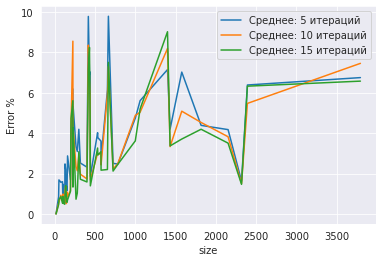

3.532466582877967 3.0086479474454975 2.72051513855623


In [12]:
tabu_lkh = defaultdict(list)
get_data('./quality/TabuLKH', tabu_lkh, lkh_sol)
frame = pd.DataFrame(tabu_lkh)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_average', data=frame, label='Среднее: 5 итераций')
sns.lineplot(x="size", y='10_average', data=frame, label='Среднее: 10 итераций')
sns.lineplot(x="size", y='15_average', data=frame, label='Среднее: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lkh_average.png")
plt.show()
print(frame['5_average'].mean(), frame['10_average'].mean(), frame['15_average'].mean())

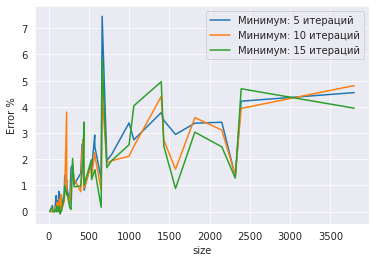

1.6065145801790364 1.4055586231116814 1.3166549630658617


In [13]:
tabu_lkh = defaultdict(list)
get_data('./quality/TabuLKH', tabu_lkh, lkh_sol)
frame = pd.DataFrame(tabu_lkh)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_min', data=frame, label='Минимум: 5 итераций')
sns.lineplot(x="size", y='10_min', data=frame, label='Минимум: 10 итераций')
sns.lineplot(x="size", y='15_min', data=frame, label='Минимум: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lkh_min.png")
plt.show()
print(frame['5_min'].mean(), frame['10_min'].mean(), frame['15_min'].mean())

# Tabu with LKH, swaps = 4

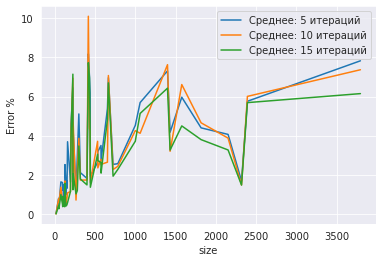

3.3078157181823173 2.8307235328968847 2.5666346668116953


In [14]:
tabu_lkh4 = defaultdict(list)
get_data('./quality/TabuLKH4', tabu_lkh4, lkh_sol)
frame = pd.DataFrame(tabu_lkh4)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_average', data=frame, label='Среднее: 5 итераций')
sns.lineplot(x="size", y='10_average', data=frame, label='Среднее: 10 итераций')
sns.lineplot(x="size", y='15_average', data=frame, label='Среднее: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lkh4_average.png")
plt.show()
print(frame['5_average'].mean(), frame['10_average'].mean(), frame['15_average'].mean())

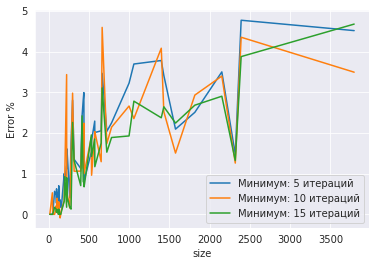

1.613665781384758 1.37980779599288 1.1455353069152918


In [15]:
tabu_lkh4 = defaultdict(list)
get_data('./quality/TabuLKH4', tabu_lkh4, lkh_sol)
frame = pd.DataFrame(tabu_lkh4)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_min', data=frame, label='Минимум: 5 итераций')
sns.lineplot(x="size", y='10_min', data=frame, label='Минимум: 10 итераций')
sns.lineplot(x="size", y='15_min', data=frame, label='Минимум: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"lkh4_min.png")
plt.show()
print(frame['5_min'].mean(), frame['10_min'].mean(), frame['15_min'].mean())

# Tabu with 2-opt

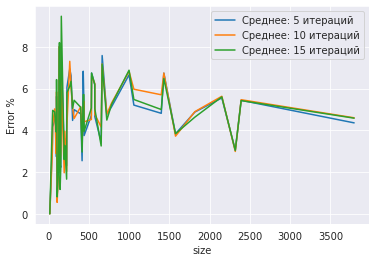

4.610250094068815 4.557183554604692 4.662864983466208


In [16]:
tabu_two = defaultdict(list)
get_data('./quality/TabuTwo', tabu_two, lkh_sol)
frame = pd.DataFrame(tabu_two)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_average', data=frame, label='Среднее: 5 итераций')
sns.lineplot(x="size", y='10_average', data=frame, label='Среднее: 10 итераций')
sns.lineplot(x="size", y='15_average', data=frame, label='Среднее: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"two_opt_average.png")
plt.show()
print(frame['5_average'].mean(), frame['10_average'].mean(), frame['15_average'].mean())

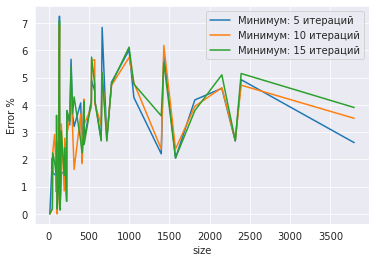

3.0029354922221554 2.983534090230556 3.1565728014172953


In [17]:
tabu_two = defaultdict(list)
get_data('./quality/TabuTwo', tabu_two, lkh_sol)
frame = pd.DataFrame(tabu_two)
frame = frame.sort_values(by=['size'])
sns.lineplot(x="size", y='5_min', data=frame, label='Минимум: 5 итераций')
sns.lineplot(x="size", y='10_min', data=frame, label='Минимум: 10 итераций')
sns.lineplot(x="size", y='15_min', data=frame, label='Минимум: 15 итераций')
plt.ylabel('Error %')
plt.savefig(f"two_opt_min.png")
plt.show()
print(frame['5_min'].mean(), frame['10_min'].mean(), frame['15_min'].mean())

In [18]:
from lin_kernighan.tabu_proc_search import TabuProcSearch

In [19]:
def mp_test_lkhs(matrix, iterations):
    t_start = time()
    searcher = LKHSearch(matrix=matrix, two_opt=True, init='two_opt')
    searcher.optimize(iterations=iterations)
    return (time() - t_start) / iterations, searcher.length

def mp_runner_lkhs(path, name, iterations, proc):
    start = time()
    logger(f'Start: {name}, {ctime()}\n')
    
    points_dict = tsp.load(path).as_dict()['node_coords']
    points = np.zeros((len(points_dict), 2), dtype=np.float)
    for key, point in points_dict.items():
        points[key - 1][0], points[key - 1][1] = point[0], point[1]
    matrix = adjacency_matrix(points)
    frame = defaultdict(list)
    
    args = [(matrix, iterations)] * proc
    
    with mp.Pool(proc) as p:
        result = p.starmap(mp_test_lkhs, args)
    
    for _time, _length in result:
        frame['time'].append(_time)
        frame['length'].append(_length)
    
    logger(f'Done: {ctime()}, time: {(time() - start) / 60} min\n')
    
    return pd.DataFrame(frame)

def mp_run_tabu_proc(path, name, iterations, swap, proc):
    start = time()
    logger(f'Start: {name}, {ctime()}\n')

    path = path
    points_dict = tsp.load(path).as_dict()['node_coords']
    points = np.zeros((len(points_dict), 2), dtype=np.float)
    for key, point in points_dict.items():
        points[key - 1][0], points[key - 1][1] = point[0], point[1]
    matrix = adjacency_matrix(points)

    logger(f'Matrix: {ctime()}\n')

    search = TabuProcSearch(opt='lkh_opt', matrix=matrix, proc=proc)

    logger(f'Init: {ctime()}\n')

    search.optimize(iterations=10, swap=8)

    logger(f'Done: {ctime()},\n length: {search.length},\n time: {(time() - start) / 60} min\n')
    logger(f'{search.tour.tolist()}\n')

In [20]:
rl5915 = pd.read_csv(f'rl5915.csv')
print(rl5915['time'].max() / 60, 'min')
print(100 / 565544 * rl5915['length'].min() - 100, '%')

8.349624402920405 min
3.13802379581756 %


In [21]:
rl5934 = pd.read_csv(f'rl5934.csv')
print(rl5934['time'].max() / 60, 'min')
print(100 / 556050 * rl5934['length'].min() - 100, '%')

8.886078337430954 min
3.2363132625960276 %


In [22]:
pla7397 = pd.read_csv(f'pla7397.csv')
print(pla7397['time'].max() / 60, 'min')
print(100 / 23260728 * pla7397['length'].min() - 100, '%')

24.753486489852264 min
3.0002150019762865 %
